# Anomaly Detection Algorithm
## Using Density Estimation by detecting outliers in Gaussian Distribution
### This is an implementation of Anomaly Detection Algorithm, based on the lecture of Andrew NG on the corresponding topic in Coursera.
### The dataset used (server latency vs throughput) is downloaded from the assignment of same course (converted from matlab data file to csv file)

In [24]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import os
from textwrap import wrap

# Set default fontsize and colors for graphs
SMALL_SIZE, MEDIUM_SIZE, BIG_SIZE = 8, 12, 16
plt.rc('font', size=MEDIUM_SIZE)       
plt.rc('axes', titlesize=BIG_SIZE)     
plt.rc('axes', labelsize=MEDIUM_SIZE)  
plt.rc('xtick', labelsize=MEDIUM_SIZE) 
plt.rc('ytick', labelsize=MEDIUM_SIZE) 
plt.rc('legend', fontsize=SMALL_SIZE)  
plt.rc('figure', titlesize=BIG_SIZE)
my_colors = 'rgbkymc'

# Disable scrolling for long output
from IPython.display import display, Javascript
disable_js = """
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}
"""
display(Javascript(disable_js))

<IPython.core.display.Javascript object>

## (1) Read Data and Perform Basic Data Analysis

In [25]:
# Read the input training and test data
input_data_dir = "C:\Study\DataSets\_Collection_of_Datasets"
input_data_file = "server_anomaly_with_output.csv"
input_data_path = os.path.join(input_data_dir, input_data_file)

train_data = pd.read_csv(input_data_path)
train_data.head(5)

,Latency,Throughput,Class
0,15.790260,14.921024,0
1,13.639619,15.329955,0
2,14.865899,16.473865,0
3,13.584676,13.989306,0
4,13.464042,15.635330,0


In [26]:
train_data.shape

(307, 3)

In [27]:
print("% of +ve (anomalous) example =", train_data[train_data.Class == 1].shape[0]/train_data.shape[0]*100)
print("% of -ve (non-anomalous) example =", train_data[train_data.Class == 0].shape[0]/train_data.shape[0]*100)

% of +ve (anomalous) example = 2.9315960912052117
% of -ve (non-anomalous) example = 97.06840390879479


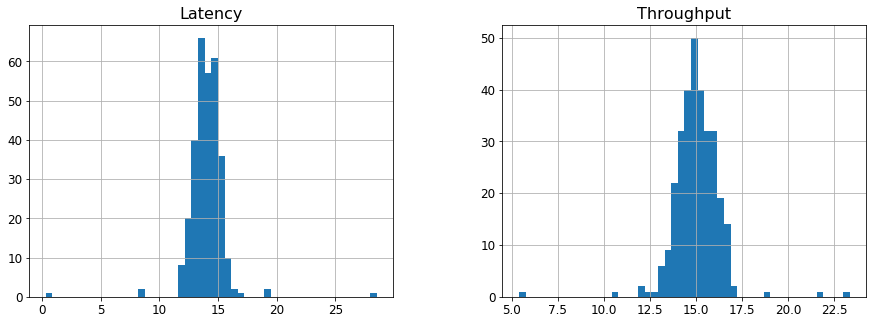

In [28]:
# Plot distribution of all features (except Class)
train_data.iloc[:,0:2].hist(figsize=(15,5), bins=50)
plt.show()

In [29]:
# Find index of Positive and Negative data
idxPos = np.where(train_data.Class == 1)
idxNeg = np.where(train_data.Class == 0)

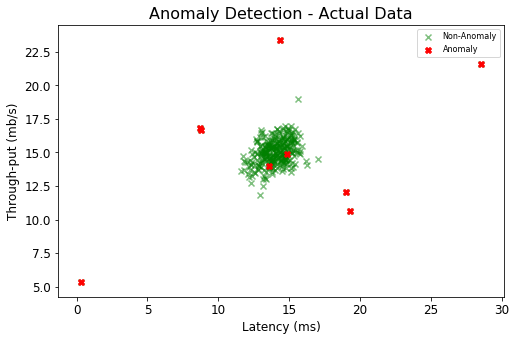

In [30]:
# Plot through-put (mb/s) vs latency (ms)
fig, axes = plt.subplots(figsize=(8,5))

axes.scatter(train_data.Latency, train_data.Throughput, alpha=0.5, marker='x', color='green', label='Non-Anomaly')
axes.scatter(train_data.iloc[idxPos].Latency, train_data.iloc[idxPos].Throughput, 
             marker='X', color='red', label='Anomaly')
axes.legend()
axes.set_xlabel('Latency (ms)')
axes.set_ylabel('Through-put (mb/s)')
axes.set_title('Anomaly Detection - Actual Data')

plt.show()

## (2) Setup Data

In [31]:
# Set train data - Features and Target
train_y = train_data.Class
train_X = train_data.drop(['Class'], axis=1)

train_X.shape, train_y.shape

((307, 2), (307,))

In [32]:
# Set test data
test_X = train_X.values
test_X.shape

(307, 2)

## (3)(a) Implementation of Anomaly Detection Algorithm - Method 1
### Using mean and variance

In [33]:
# Estimate Gaussian Parameters - mean and variance
def estimateGaussainParams(train_X):
    mean_X = np.mean(train_X, axis=0).values.reshape(1,-1)
    var_X = np.var(train_X, axis=0).values.reshape(1,-1)
    return mean_X, var_X

In [34]:
# Compute PDF
def computeProbability(test_X, mean_X, var_X):
    prob = (1/np.sqrt(2*np.pi*var_X)) * np.exp(-(test_X - mean_X)**2/(2*var_X))
    return prob

## (3)(b) Implementation of Anomaly Detection Algorithm - Method 2
### Using mean and co-variance

In [35]:
def estimateMultiVariateGaussainParams(train_X):
    mean_X = np.mean(train_X, axis=0).values.reshape(1,-1)
    cov_X = np.cov(train_X, rowvar=False)
    return mean_X, cov_X

In [36]:
def computeMultiVariateProbability(test_X, mean_X, cov_X):
    n = mean_X.shape[1]
    X = (test_X - mean_X)
    denominator = ((2*np.pi)**(n/2)) * ((np.linalg.det(cov_X))**(1/2))
    numerator = np.exp(-0.5 * np.sum(np.dot(X, np.linalg.inv(cov_X)) * X, axis=1))
    probability = numerator / denominator
    return probability

## (4) Utility Functions
### For testing the implementation of Anomaly Detection Algorithm

In [37]:
# Plot Distribution of Calculated PDF
def plotProbabilityDistribution(pX):
    fig, axes = plt.subplots(figsize=(8,5))
    sns.distplot(pX[idxPos], color='r', label='Anomaly', kde=False, bins=50, ax=axes)
    sns.distplot(pX[idxNeg], color='g', label='Non-Anomaly', kde=False, bins=50, ax=axes)
    axes.set_xlim(0,)
    axes.legend()
    axes.set_xlabel('Probability')
    axes.set_ylabel('Count')
    axes.set_title('Distribution of Calculated Probability')
    plt.show()

In [50]:
# Find out best threshold (epsilon) value
def selectThreshold(pX, train_y):
    bestEpsilon = 0
    bestF1 = 0
    F1 = 0
    prediction = np.zeros(train_y.shape)
    stepSize = (max(pX) - min(pX))/1000
    
    for epsilon in np.arange(min(pX), max(pX), stepSize):
        prediction = pX < epsilon
        prediction = prediction.reshape(train_y.shape)
        tp = np.sum(np.logical_and((prediction == 1), (train_y == 1)))
        fp = np.sum(np.logical_and((prediction == 1), (train_y == 0)))
        fn = np.sum(np.logical_and((prediction == 0), (train_y == 1)))
        
        precision = tp/(tp + fp)
        recall = tp/(tp + fn)
        
        F1 = (2 * precision * recall)/(precision + recall)
        
        if F1 > bestF1:
            bestF1 = F1
            bestEpsilon = epsilon
            bestPrecision = precision
            bestRecall = recall
            
    return bestEpsilon, bestF1, bestPrecision, bestRecall

In [51]:
def testPredictionAccuracy(pX, train_y):
    optimalEpsilon, bestF1, bestPrecision, bestRecall = selectThreshold(pX, train_y)
    print("Optimal Epsilon =", optimalEpsilon)
    print("Best F1 Score =", bestF1)
    print("Best Precision Value =", bestPrecision)
    print("Best Recall Value =", bestRecall)

    pred = pX < optimalEpsilon
    print("Accuracy of prediction =", np.mean(pred == train_y)*100, "%")
    return pred

In [40]:
# Find index of Positive and Negative data based on predictions
def plotAnomalyOnTrainingData(train_data, predictions):
    idxPredPos = np.where(predictions == 1)
    idxPredNeg = np.where(predictions == 0)

    # Plot through-put (mb/s) vs latency (ms) - Predictions
    fig, axes = plt.subplots(figsize=(8,5))

    axes.scatter(train_data.Latency, train_data.Throughput, alpha=0.5, marker='x', color='green', label='Non-Anomaly')
    axes.scatter(train_data.iloc[idxPos].Latency, train_data.iloc[idxPos].Throughput, 
                 s=50, marker='X', color='red', label='Anomaly')
    axes.scatter(train_data.iloc[idxPredPos].Latency, train_data.iloc[idxPredPos].Throughput, 
                 marker='o', label='Predicted-Anomaly',
                 s=200, facecolors='none', edgecolors='red')
    axes.legend()
    axes.set_xlabel('Latency (ms)')
    axes.set_ylabel('Through-put (mb/s)')
    axes.set_title('Anomaly Detection - Actual vs Predicted')

    plt.show()

## (4) Test my implementations

### (4a) Test Method 1

In [41]:
# Perform Anomaly Detection - Method 1
mean_X, var_X = estimateGaussainParams(train_X)
prob_matrix = computeProbability(test_X, mean_X, var_X)
pX = np.prod(prob_matrix, axis=1)
#print("Probability =", pX)

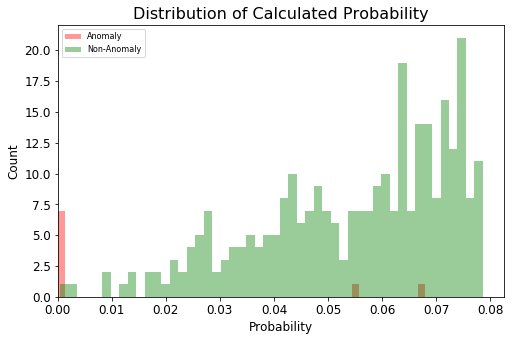

In [42]:
plotProbabilityDistribution(pX)

In [52]:
predictions1 = testPredictionAccuracy(pX, train_y)

Optimal Epsilon = 0.00015729462574407373
Best F1 Score = 0.8750000000000001
Best Precision Value = 1.0
Best Recall Value = 0.7777777777777778
Accuracy of prediction = 99.3485342019544 %


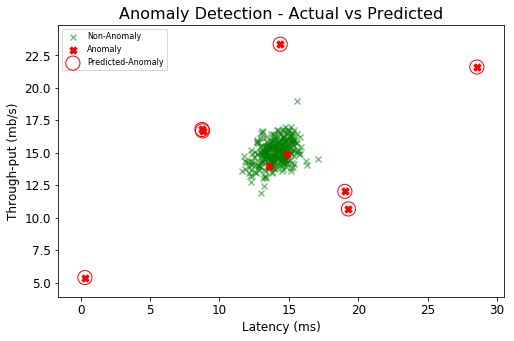

In [44]:
plotAnomalyOnTrainingData(train_data, predictions1)

### (4b) Test Method 2

In [45]:
# Perform Anomaly Detection - Method 2
mean_X, cov_X = estimateMultiVariateGaussainParams(train_X)
prob_matrix = computeMultiVariateProbability(test_X, mean_X, cov_X)
pMVX = prob_matrix

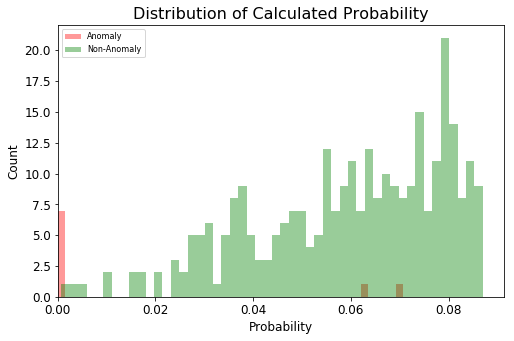

In [46]:
plotProbabilityDistribution(pMVX)

In [53]:
predictions2 = testPredictionAccuracy(pMVX, train_y)

Optimal Epsilon = 8.70194606335004e-05
Best F1 Score = 0.8750000000000001
Best Precision Value = 1.0
Best Recall Value = 0.7777777777777778
Accuracy of prediction = 99.3485342019544 %


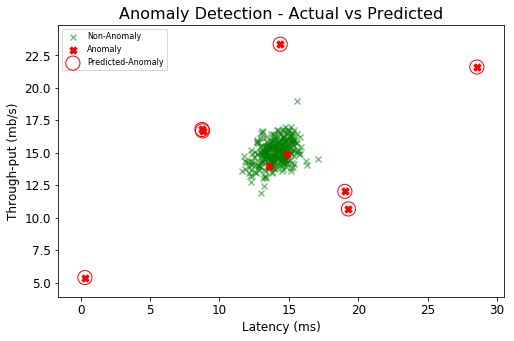

In [48]:
plotAnomalyOnTrainingData(train_data, predictions2)